In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import keras
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
 
 

Using TensorFlow backend.


In [49]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

#optimizer = Adam(0.0002, 0.5)

def build_generator():
    
    with tf.device('/gpu:1'):
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)
    #modelout=keras.utils.multi_gpu_model(Model(noise, img),gpus=8)
    return Model(noise, img)

def build_discriminator():
    with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)
    #modelout=keras.utils.multi_gpu_model(Model(img, validity),gpus=8)
    return Model(img, validity)




In [52]:
keras.backend.clear_session()
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
optimizer=Adam(0.0002, 0.5),
metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.978774, acc.: 37.50%] [G loss: 0.962123]


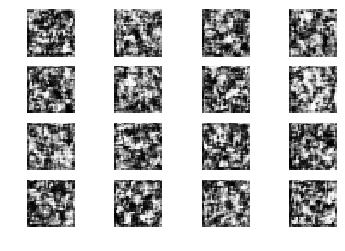

250 [D loss: 0.825303, acc.: 53.12%] [G loss: 1.789668]


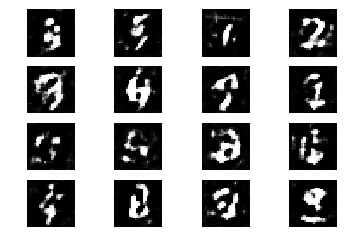

500 [D loss: 0.721788, acc.: 57.42%] [G loss: 1.720218]


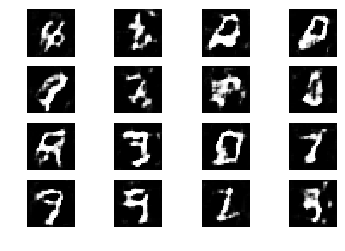

750 [D loss: 0.703508, acc.: 58.98%] [G loss: 1.735979]


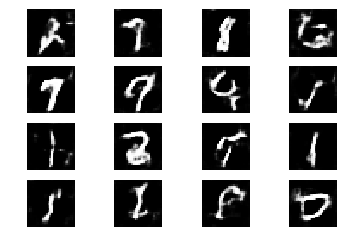

1000 [D loss: 0.658227, acc.: 58.98%] [G loss: 1.663879]


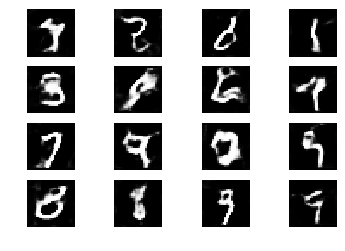

1250 [D loss: 0.707164, acc.: 58.98%] [G loss: 1.591414]


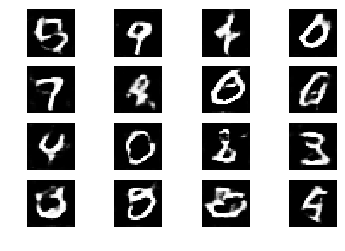

1500 [D loss: 0.664762, acc.: 61.72%] [G loss: 1.539257]


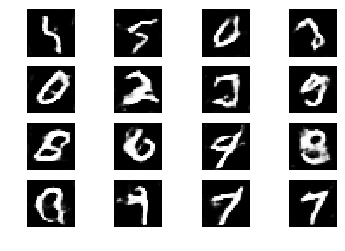

1750 [D loss: 0.684426, acc.: 60.16%] [G loss: 1.673454]


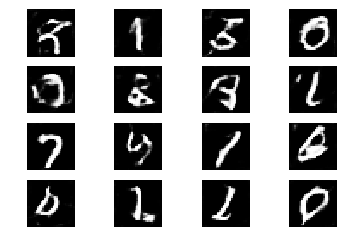

2000 [D loss: 0.657982, acc.: 58.59%] [G loss: 1.580875]


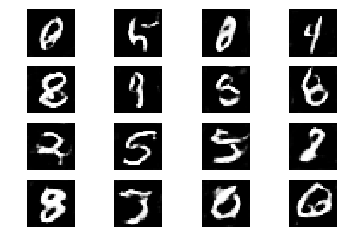

2250 [D loss: 0.615300, acc.: 65.62%] [G loss: 1.671431]


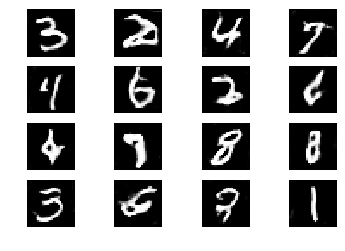

2500 [D loss: 0.622581, acc.: 65.23%] [G loss: 1.685043]


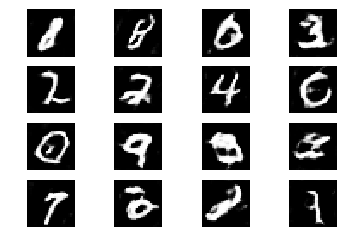

2750 [D loss: 0.660654, acc.: 66.02%] [G loss: 1.696799]


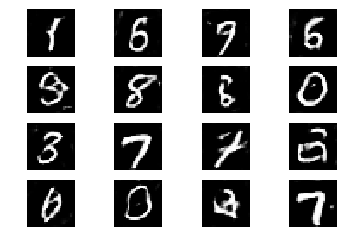

3000 [D loss: 0.714438, acc.: 56.64%] [G loss: 1.607840]


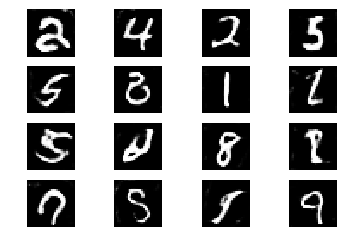

3250 [D loss: 0.637385, acc.: 64.45%] [G loss: 1.869970]


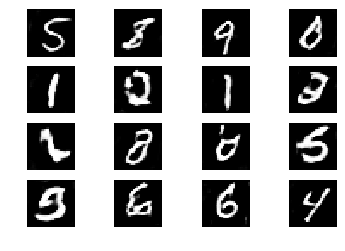

3500 [D loss: 0.706760, acc.: 59.77%] [G loss: 1.513511]


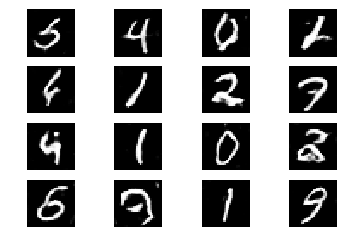

3750 [D loss: 0.645037, acc.: 63.28%] [G loss: 1.694987]


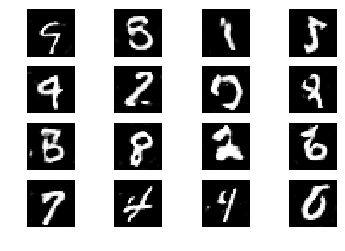

4000 [D loss: 0.644269, acc.: 64.84%] [G loss: 1.564240]


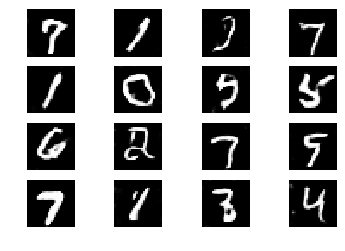

4250 [D loss: 0.751533, acc.: 55.47%] [G loss: 1.729864]


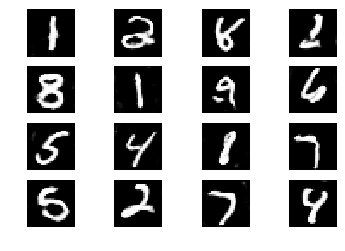

4500 [D loss: 0.628491, acc.: 64.06%] [G loss: 1.917876]


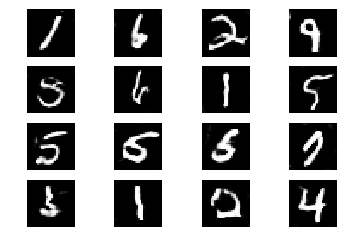

4750 [D loss: 0.642885, acc.: 65.62%] [G loss: 1.740397]


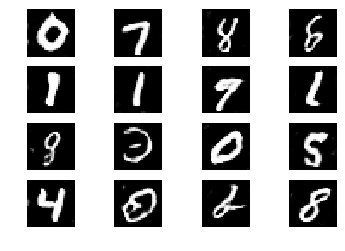

In [53]:
def train( epochs, batch_size=128, sample_interval=250):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        if epoch % sample_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            plot_imgs()

        # If at save interval => save generated image samples
#         if epoch % sample_interval == 0:
#             sample_images(epoch)

train(5000)

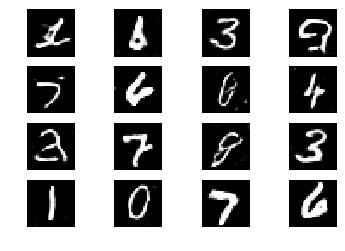

In [57]:
import matplotlib.pyplot as plt
def plot_imgs():
    noise = np.random.normal(0, 1, (4 * 4, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
plot_imgs()